In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import cv2
import itertools
import os
import sys
import shutil
import glob
import random
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline

In [2]:
!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -uq "/content/drive/My Drive/archive.zip" -d "/content/drive/My Drive/Data"

**CREATING TRAIN, VALIDATION AND TEST SETS** 

In [5]:
# PREPROCESSING PARAMS
TRAIN_SIZE = 700
TEST_SIZE = 700
VALID_SIZE = 700

In [6]:
"""
- creating the different sets with respective percentages
- NOTE: dataset is imbalanced, used a fixed size of 700 for each set
"""

original_data_path = "/content/drive/MyDrive/Data"

os.chdir("./")
if os.path.isdir("train/0") is False:
    # create folders for the sets
    os.mkdir("./train")
    os.mkdir("./test")
    os.mkdir("./valid")
    
    # move X number of instances from original set, to respective sets
    for i in range(0, 5):
        # path to inputs with different classes
        num_folder_path = f'{original_data_path}/{i}' 
        num_files_in_folder = len(os.listdir(num_folder_path))

        train_size = TRAIN_SIZE
        test_size = TEST_SIZE
        valid_size = VALID_SIZE
        
        # make classes within set
        os.mkdir(f'train/{i}')
        os.mkdir(f'test/{i}')
        os.mkdir(f'valid/{i}')
        
        test_samples = random.sample(os.listdir(num_folder_path), test_size)
        for file_name in test_samples:
            shutil.copy((f"/content/drive/MyDrive/Data/{i}/{file_name}"), f'./test/{i}')

        train_samples = random.sample(os.listdir(num_folder_path), train_size)
        for file_name in train_samples:
            shutil.copy((f"/content/drive/MyDrive/Data/{i}/{file_name}"), f'./train/{i}')
            
        valid_samples = random.sample(os.listdir(num_folder_path), valid_size)
        for file_name in valid_samples:
            shutil.copy((f"/content/drive/MyDrive/Data/{i}/{file_name}"), f'./valid/{i}')

In [7]:
# train,test, and valid set paths
TRAIN_PATH = "./train"
TEST_PATH = "./test"
VALID_PATH = "./valid"

**DATA PREPROCESSING**

In [8]:
# preprocessing/augmentation for ImageDataGenerator
def preprocesser(image):
    image= tf.image.adjust_contrast(image, 0.6)
    image = tfa.image.equalize(image)
    image = tf.image.rgb_to_grayscale(image)
    return image

In [9]:
# generating sets
PREPROCESSING_FUNC = preprocesser
CLASS_MODE = "categorical"
BATCH_SIZE = 32

train_batches = ImageDataGenerator(
    preprocessing_function = PREPROCESSING_FUNC, 
    rescale=1./255, 
    horizontal_flip=True).flow_from_directory(directory = TRAIN_PATH, 
                                              target_size = (224,224), 
                                              batch_size = BATCH_SIZE, 
                                              class_mode=CLASS_MODE)
    
test_batches = ImageDataGenerator(
    preprocessing_function = PREPROCESSING_FUNC, 
    rescale=1./255).flow_from_directory(directory = TEST_PATH, 
                                        target_size = (224,224), 
                                        batch_size = BATCH_SIZE, 
                                        class_mode=CLASS_MODE, 
                                        shuffle=False)
    
valid_batches = ImageDataGenerator(
    preprocessing_function = PREPROCESSING_FUNC, 
    rescale=1./255).flow_from_directory(directory = VALID_PATH, 
                                        target_size = (224,224), 
                                        batch_size = BATCH_SIZE, 
                                        shuffle = False, 
                                        class_mode=CLASS_MODE)

Found 3500 images belonging to 5 classes.
Found 3500 images belonging to 5 classes.
Found 3500 images belonging to 5 classes.


In [10]:
# checking if ImageDataGenerator assigned proper labels
train_batches.labels

array([0, 0, 0, ..., 4, 4, 4], dtype=int32)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


<Figure size 432x288 with 0 Axes>

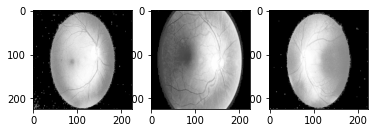

In [11]:
# what the inputs/images look like after augmentation

plt.figure()
f, axarr = plt.subplots(1,3)
for i in range (0,3):
    random_num = random.randint(0,100)
    image = train_batches[random_num]
    axarr[i].imshow(image[0][0])
    print(np.shape(image[0][0]))

**MODEL BUILDING**

In [12]:
# MODEL PARAMS - change here
NUM_EPOCH = 50
LEARNING_RATE = 0.001
FREEZE_LAYERS = -6
LOSS_FUNC = "categorical_crossentropy"
TRAIL_NUM = 1
SECOND_PASS = False # change to True when fine tuning after training new output layer
PATIENCE = 25
NUM_CLASSES = 5

In [13]:
# importing MobileNetv2 - original, excluding the final/output layer
model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [14]:
for layer in model.layers: # originally 23
    layer.trainable = SECOND_PASS # should be False on first run

In [15]:
# adding new output layer to MobileNetV2, specific to our problem
x = Flatten()(model.output)
output = Dense(units=5, activation="softmax")(x) # 5 units for, 1 for each class

In [16]:
model = Model(inputs = model.input, outputs = output)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

**MODEL TRAINING**

In [18]:
# number of training params in MobileNetV2 model with new output layer
trainable_params_freeze = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
non_trainable_params_freeze = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
print(f"trainable params: {trainable_params_freeze}\nnon trainable params: {non_trainable_params_freeze}")

trainable params: 313605
non trainable params: 2257984


In [19]:
model.compile(optimizer=Adam(lr=LEARNING_RATE), loss=LOSS_FUNC, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
# early stopping enabled, controlled with PATIENCE variable
model.fit_generator(train_batches, validation_data=valid_batches, epochs=NUM_EPOCH, verbose=2, callbacks=EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
110/110 - 287s - loss: 6.6188 - accuracy: 0.3540 - val_loss: 8.5959 - val_accuracy: 0.3860 - 287s/epoch - 3s/step
Epoch 2/50
110/110 - 282s - loss: 4.3393 - accuracy: 0.4586 - val_loss: 6.5066 - val_accuracy: 0.4331 - 282s/epoch - 3s/step
Epoch 3/50
110/110 - 280s - loss: 4.3077 - accuracy: 0.5243 - val_loss: 8.3264 - val_accuracy: 0.3931 - 280s/epoch - 3s/step
Epoch 4/50
110/110 - 278s - loss: 3.3559 - accuracy: 0.5986 - val_loss: 5.3100 - val_accuracy: 0.4920 - 278s/epoch - 3s/step
Epoch 5/50
110/110 - 276s - loss: 2.2738 - accuracy: 0.6766 - val_loss: 4.3921 - val_accuracy: 0.5043 - 276s/epoch - 3s/step
Epoch 6/50
110/110 - 277s - loss: 2.0750 - accuracy: 0.7046 - val_loss: 5.1478 - val_accuracy: 0.5143 - 277s/epoch - 3s/step
Epoch 7/50
110/110 - 280s - loss: 1.7709 - accuracy: 0.7397 - val_loss: 4.7935 - val_accuracy: 0.5557 - 280s/epoch - 3s/step
Epoch 8/50
110/110 - 276s - loss: 1.3756 - accuracy: 0.7814 - val_loss: 4.9827 - val_accuracy: 0.5437 - 276s/epoch - 3s/step


In [29]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [32]:
model.save('model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [33]:
import shutil
shutil.copy('/content/model.h5','/content/drive/MyDrive')

'/content/drive/MyDrive/model.h5'

**PERFORMANCE EVALUATION**

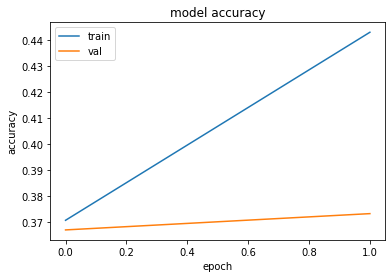

In [34]:
# only needed if training, use after training

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

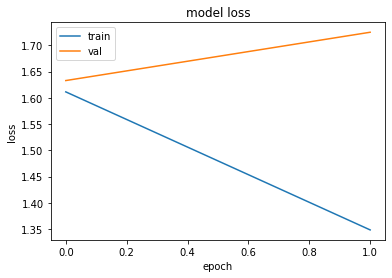

In [35]:
# only needed if training, use after training

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
# proper labels 
proper_labels = {
    0: "no DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

In [37]:
# get actual class of a single instance

def actual_class(img_path):
    path = os.path.dirname(img_path)
    class_num = path[-1]
    real_class = proper_labels.get(int(class_num))
    return (real_class, class_num)

In [38]:
# loading already trained model via path
trained_model_path = "/content/model.h5"
loaded_model = keras.models.load_model(trained_model_path)

**CONFUSION MATRIX FOR TEST SET**

In [39]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
# evaluation -> loss, acc (from keras)
test_eval = loaded_model.evaluate(test_batches, verbose=0)
print(f'test loss, test acc: {test_eval}')

test loss, test acc: [1.6831706762313843, 0.3805714249610901]


In [41]:
# prediction -> confusion matrix (custom function)
predictions = loaded_model.predict(test_batches, verbose=0)

In [42]:
test_labels = test_batches.classes
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix, without normalization
[[237 120 233  33  77]
 [204 148 252  36  60]
 [132 110 232  58 168]
 [ 68  46 163 156 267]
 [ 15  12  62  52 559]]


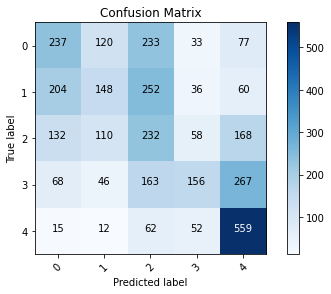

In [43]:
cm_plot_labels = ["0", "1", "2", "3", "4"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [44]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

pred_arr = predictions.argmax(1)

test_acc = accuracy_score(y_true=test_labels, y_pred=pred_arr)
test_recall = recall_score(y_true=test_labels, y_pred=pred_arr, average="macro")
test_precision = precision_score(y_true=test_labels, y_pred=pred_arr, average="macro")

print(f'acc: {test_acc}, recall: {test_recall}, precision: {test_precision}')

acc: 0.38057142857142856, recall: 0.3805714285714286, precision: 0.38138780910102316


In [45]:
from sklearn.metrics import roc_curve, auc, f1_score
test_f1_score = f1_score(test_labels, pred_arr, average="macro")

fpr, tpr, thresholds = roc_curve(test_labels, pred_arr, pos_label=0) # auc for class 0
test_auc = auc(fpr, tpr)

print(f'AUC: {test_auc}')

AUC: 0.30632704081632656
